In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import json
import tensorflow as tf
import argparse
import numpy as np
from pathlib import Path
from time import strftime
from shutil import rmtree
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
from rtapipe.lib.dataset.data_manager import DataManager
from rtapipe.lib.datasource.Photometry3 import OnlinePhotometry, SimulationParams
from rtapipe.lib.models.anomaly_detector_builder import AnomalyDetectorBuilder
from rtapipe.scripts.ml.offline.callbacks import CustomLogCallback
from rtapipe.lib.evaluation.custom_mse import CustomMSE
from rtapipe.lib.plotting.plotting import plot_sequences, loss_plot

## Configuration

In [3]:
output_dir = "./logs/train_models_new_data_manager_itime_1"

In [4]:
dataset_folder = "/data01/homes/baroncelli/phd/rtapipe/scripts/ml/dataset_generation/train/North_z40_5h_LST/itime_5_b/fits_data"

In [5]:
SCALER_TYPE="minmax"

In [6]:
features_names = ["EB_0.04-0.117","EB_2-0.117-0.342","EB_0.342-1"]

In [7]:
fits_files = DataManager.load_fits_data(dataset_folder, limit=10)

Loaded 10 files


In [8]:
sim_params = SimulationParams(runid="run0406_ID000126", onset=0, emin=0.04, emax=1, tmin=0, tobs=500, offset=0.5, irf="North_z40_5h_LST", roi=2.5, caldb="prod5-v0.1", simtype="bkg")

In [9]:
dataset_id="train_itime_1_a_tsl_5_nbins_3"

In [10]:
multiple_templates = False
add_target_region = False
integration_time = 1
number_of_energy_bins = 3
tsl = 500
threads = 30
normalize = True
data_manager = DataManager(output_dir)
#data_manager.transform_to_timeseries(fits_files, sim_params, add_target_region, integration_time=integration_time, number_of_energy_bins=number_of_energy_bins, tsl=tsl, normalize=normalize, threads=threads, multiple_templates=multiple_templates)
data_manager.load_saved_data(1, 500) # <--- LOAD ME

Loading cached data from notemplate_it_1_tsl_500.npy
[2022-12-20 22:41:51.204093] Loaded data from logs/train_models_new_data_manager_itime_1/data_cache


In [11]:
assert data_manager.data["notemplate"].shape == (850, 500, 3)

In [12]:
train_x, train_y , val_x, val_y = data_manager.get_train_set("notemplate", sub_window_size=5, stride=5, validation_split=80)

[2022-12-20 22:41:51.215372] Extracting subsequences of 5 points with stride 5 from 850 time series
[2022-12-20 22:41:54.421305] Extracted 85000 subsequences
[2022-12-20 22:41:54.425934] Train set shape: (68000, 5, 3) - Validation set shape: (17000, 5, 3)
[2022-12-20 22:41:54.426106] Data will be scaled to 0-1


In [13]:
train_x.shape

(68000, 5, 3)

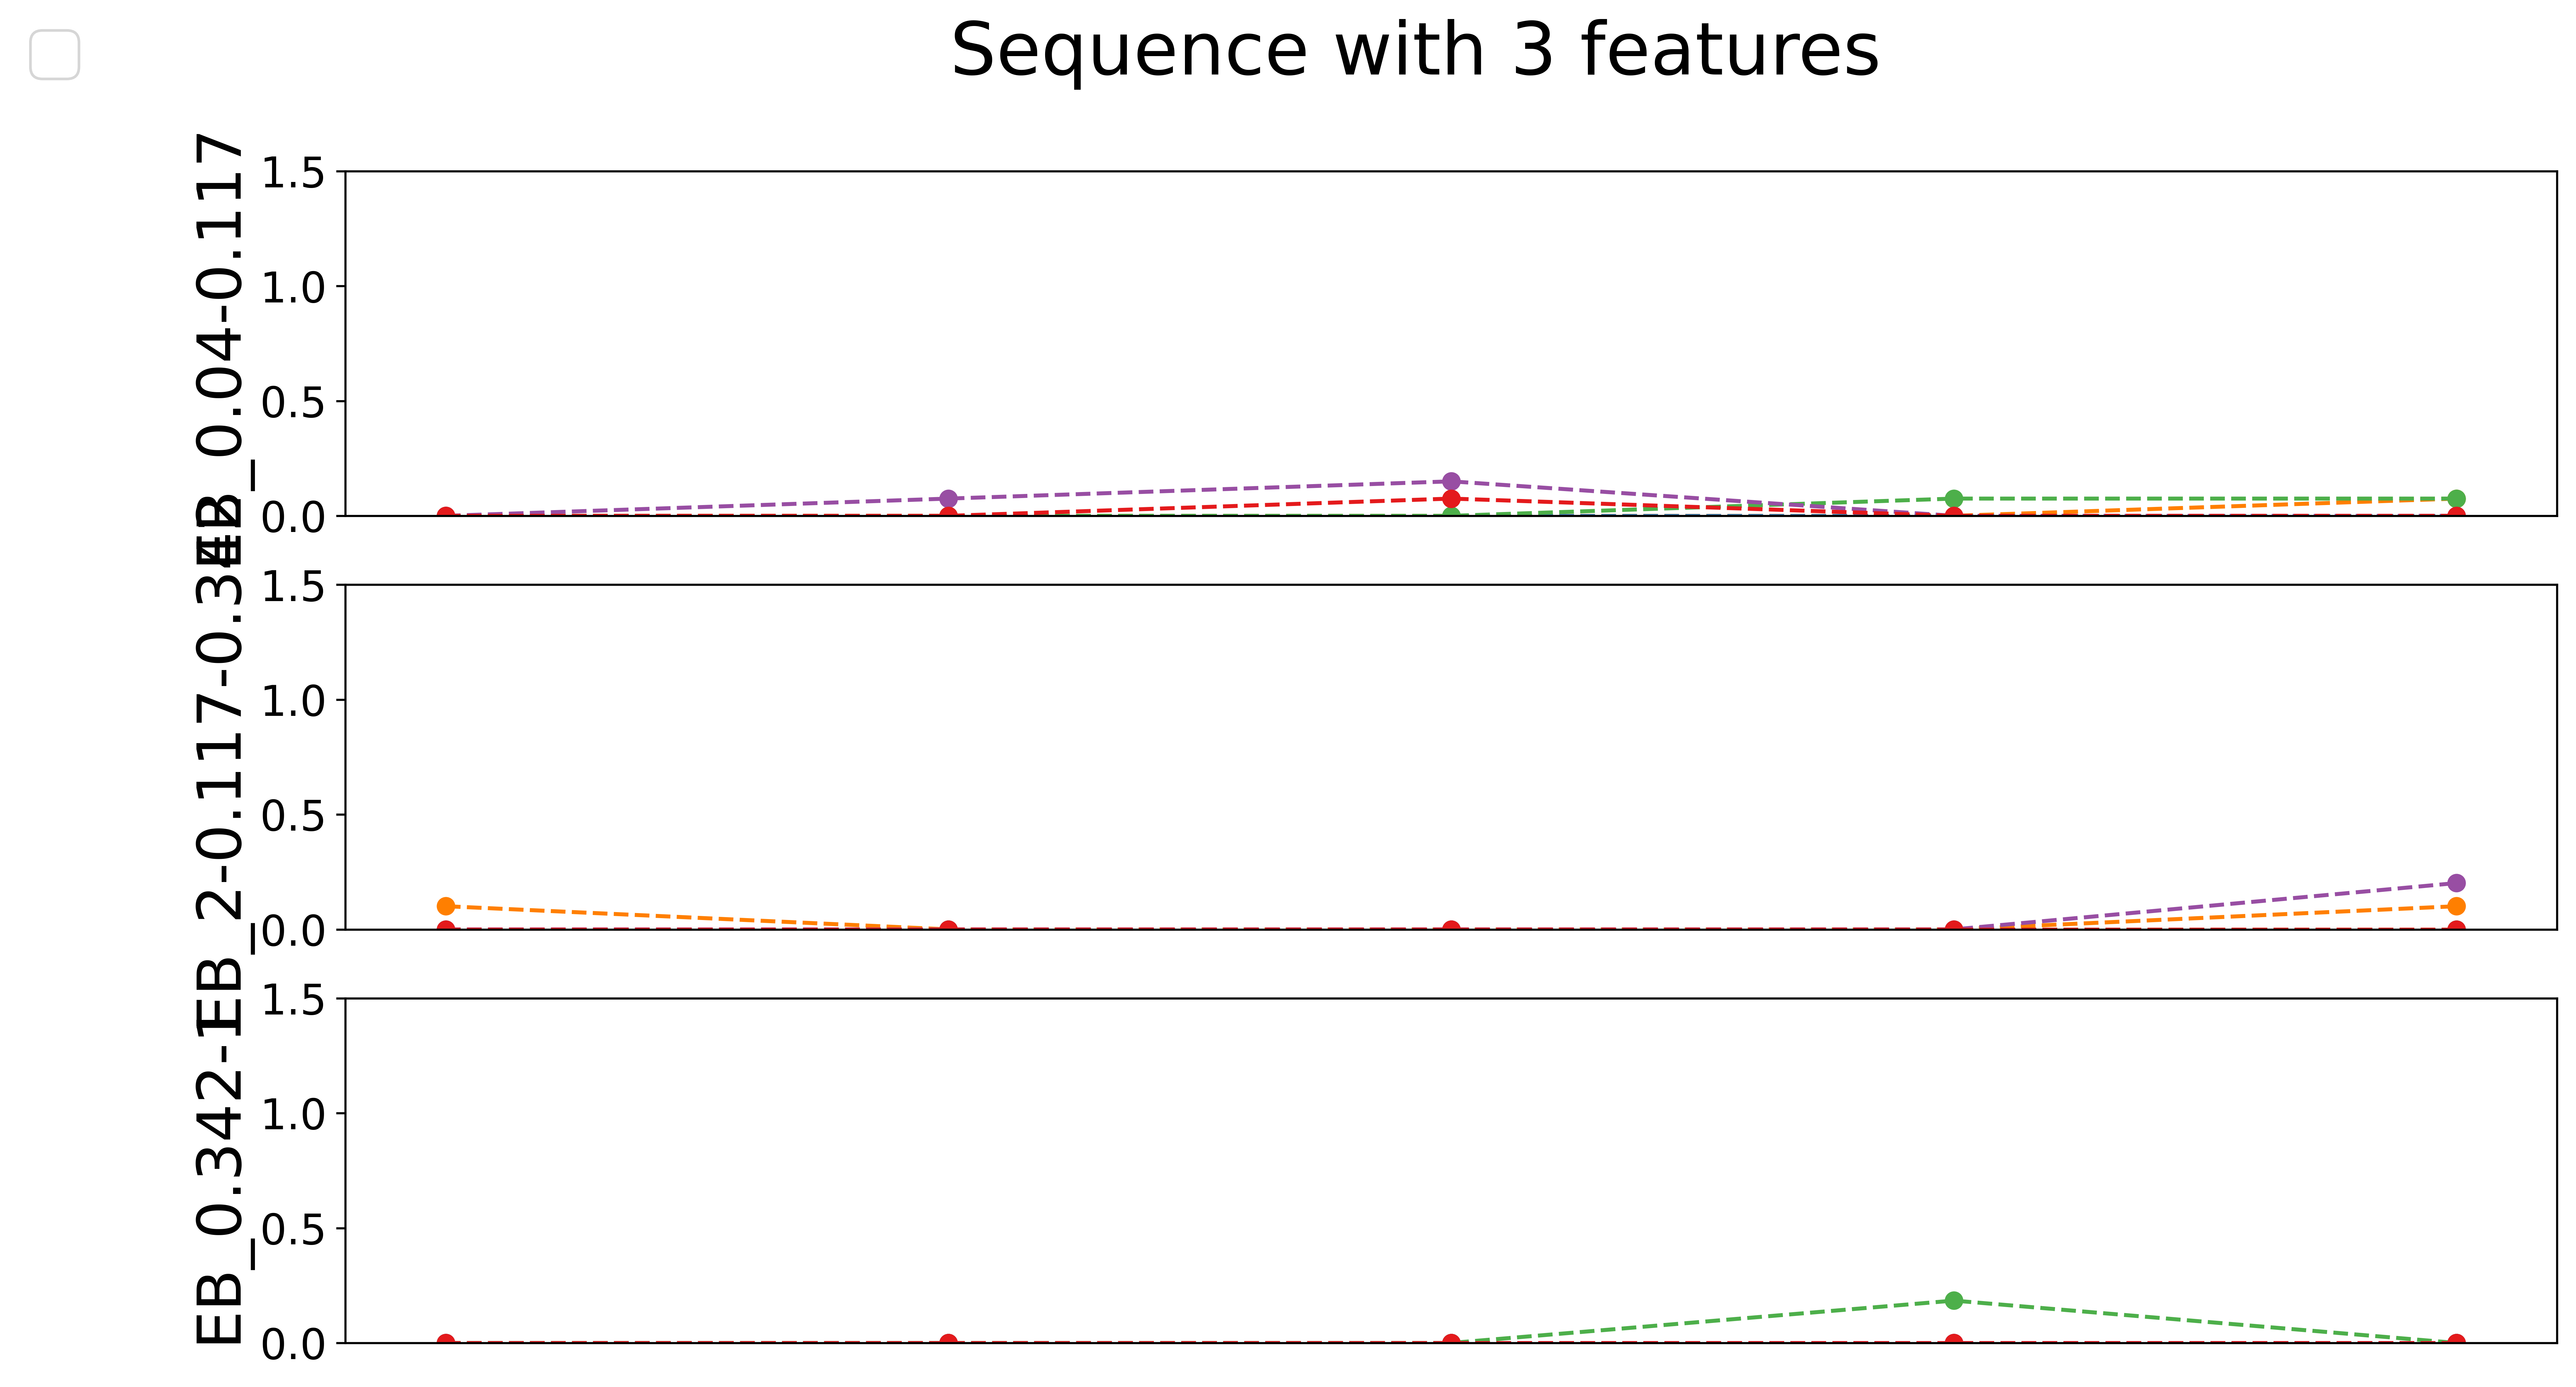

Saving sample.png


In [14]:
import matplotlib
matplotlib.use("TKAgg", force=True)
%matplotlib inline
plot_sequences(train_x[0:5], scaled=True, labels=["first sample of validation set"], features_names=features_names, showFig=True, saveFig=True)

In [15]:
model_names = AnomalyDetectorBuilder.getModelsName()

In [16]:
model_names = [model_name for model_name in model_names if "lstm" in model_name]
model_names = ["AnomalyDetector_cnn_l2_u32", "AnomalyDetector_rnn_l2_u32"]#, "AnomalyDetector_lstm_l2_u32"]

In [17]:
EARLY_STOPPING_PATIENCE=5

In [18]:
timesteps = train_x[0].shape[0]
nfeatures = train_x[0].shape[1]
batch_size = 32

outDirRoot = Path("./").parent.resolve().joinpath(f"run_{strftime('%Y%m%d-%H%M%S')}")

for model_name in model_names:
    
    print(f"\n\n\n********************* {model_name} training *********************\n\n")
    outDirBase = outDirRoot.joinpath(f"model_{model_name}_dataset_{dataset_id}_tsl_{tsl}")
    outDirBase.mkdir(parents=True, exist_ok=True)
    data_manager.store_scaler(integration_time, tsl, SCALER_TYPE, outDirBase)
    with open(outDirBase.joinpath('dataset_params.json'), 'w') as handle:
        json.dump({"id":dataset_id, "path":dataset_folder, "runid": "notemplate", "itime":5, "tsl":5, "normalized":True, "delay":0, "offset":0}, handle)

    
    # Callbacks 
    clc = CustomLogCallback(
            [1, 5, 10, 50, 100 ,200],
            validation_data=(val_x, val_y), 
            out_dir_root=outDirBase, 
            wandb_run=None, 
            metadata={"dataset_id": dataset_id, "model": model_name, "training": "heavy"}
    )
    ea = EarlyStopping(monitor="val_loss", patience=EARLY_STOPPING_PATIENCE, mode="min")
    callbacks = [
        ea, clc
    ]
    
    anomalyDetector = AnomalyDetectorBuilder.getAnomalyDetector(model_name, timesteps, nfeatures)
    anomalyDetector.model.compile(optimizer='adam', loss=CustomMSE(nfeatures, output_dir=outDirBase)) # 
    anomalyDetector.model.summary()
    anomalyDetector.store_parameters(outDirBase)

    history = anomalyDetector.model.fit(train_x, train_x, verbose=0, epochs=200, batch_size=batch_size, validation_data=(val_x, val_x), callbacks=callbacks)
    clc.on_epoch_end(None, force=True)
    loss_plot(history.history["loss"], history.history["val_loss"], model_name=model_name, title=f"Training loss", outputDir=outDirBase, figName="train_val_loss.png", showFig=False)




********************* AnomalyDetector_cnn_l2_u32 training *********************


Storing scaler to /data01/homes/baroncelli/phd/rtapipe/notebooks/run_20221220-224157/model_AnomalyDetector_cnn_l2_u32_dataset_train_itime_1_a_tsl_5_nbins_3_tsl_500/fitted_scaler_minmax_itime_1_tsl_500.pickle
AnomalyDetector_cnn_l2_u32 - input shape: (5,3)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 3, 32)             320       
_________________________________________________________________
dropout (Dropout)            (None, 3, 32)             0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 2, 32)             0         
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 5, 3)              291       
_____________________________________________

  0%|                                                                                         | 1/3400 [00:00<41:42,  1.36it/s]


Max plots reached


----------------- Checkpoint! Saving data at epoch 5 (Triggered by Early Stopping=False) -----------------
INFO:tensorflow:Assets written to: /data01/homes/baroncelli/phd/rtapipe/notebooks/run_20221220-224157/model_AnomalyDetector_cnn_l2_u32_dataset_train_itime_1_a_tsl_5_nbins_3_tsl_500/epochs/epoch_5/trained_model/assets
532/532 [==============================] - 1s 2ms/step
Plot /data01/homes/baroncelli/phd/rtapipe/notebooks/run_20221220-224157/model_AnomalyDetector_cnn_l2_u32_dataset_train_itime_1_a_tsl_5_nbins_3_tsl_500/epochs/epoch_5/reco_errors_distr_per_features.png created.
Plot /data01/homes/baroncelli/phd/rtapipe/notebooks/run_20221220-224157/model_AnomalyDetector_cnn_l2_u32_dataset_train_itime_1_a_tsl_5_nbins_3_tsl_500/epochs/epoch_5/reco_errors_distr_per_sample.png created.


  0%|                                                                                         | 1/3400 [00:00<51:20,  1.10it/s]


Max plots reached


----------------- Checkpoint! Saving data at epoch 10 (Triggered by Early Stopping=False) -----------------
INFO:tensorflow:Assets written to: /data01/homes/baroncelli/phd/rtapipe/notebooks/run_20221220-224157/model_AnomalyDetector_cnn_l2_u32_dataset_train_itime_1_a_tsl_5_nbins_3_tsl_500/epochs/epoch_10/trained_model/assets
532/532 [==============================] - 1s 1ms/step
Plot /data01/homes/baroncelli/phd/rtapipe/notebooks/run_20221220-224157/model_AnomalyDetector_cnn_l2_u32_dataset_train_itime_1_a_tsl_5_nbins_3_tsl_500/epochs/epoch_10/reco_errors_distr_per_features.png created.
Plot /data01/homes/baroncelli/phd/rtapipe/notebooks/run_20221220-224157/model_AnomalyDetector_cnn_l2_u32_dataset_train_itime_1_a_tsl_5_nbins_3_tsl_500/epochs/epoch_10/reco_errors_distr_per_sample.png created.


  0%|                                                                                         | 1/3400 [00:00<41:01,  1.38it/s]


Max plots reached


----------------- Checkpoint! Saving data at epoch 13 (Triggered by Early Stopping=True) -----------------
INFO:tensorflow:Assets written to: /data01/homes/baroncelli/phd/rtapipe/notebooks/run_20221220-224157/model_AnomalyDetector_cnn_l2_u32_dataset_train_itime_1_a_tsl_5_nbins_3_tsl_500/epochs/epoch_13/trained_model/assets
532/532 [==============================] - 1s 2ms/step
Plot /data01/homes/baroncelli/phd/rtapipe/notebooks/run_20221220-224157/model_AnomalyDetector_cnn_l2_u32_dataset_train_itime_1_a_tsl_5_nbins_3_tsl_500/epochs/epoch_13/reco_errors_distr_per_features.png created.
Plot /data01/homes/baroncelli/phd/rtapipe/notebooks/run_20221220-224157/model_AnomalyDetector_cnn_l2_u32_dataset_train_itime_1_a_tsl_5_nbins_3_tsl_500/epochs/epoch_13/reco_errors_distr_per_sample.png created.


  0%|                                                                                         | 1/3400 [00:00<50:30,  1.12it/s]


Max plots reached
Plot /data01/homes/baroncelli/phd/rtapipe/notebooks/run_20221220-224157/model_AnomalyDetector_cnn_l2_u32_dataset_train_itime_1_a_tsl_5_nbins_3_tsl_500/AnomalyDetector_cnn_l2_u32_train_val_loss.png created.



********************* AnomalyDetector_rnn_l2_u32 training *********************


Storing scaler to /data01/homes/baroncelli/phd/rtapipe/notebooks/run_20221220-224157/model_AnomalyDetector_rnn_l2_u32_dataset_train_itime_1_a_tsl_5_nbins_3_tsl_500/fitted_scaler_minmax_itime_1_tsl_500.pickle
AnomalyDetector_rnn_l2_u32 - input shape: (5,3)
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 32)                1152      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
repeat_vector (Re

  0%|                                                                                         | 1/3400 [00:00<40:22,  1.40it/s]


Max plots reached


----------------- Checkpoint! Saving data at epoch 5 (Triggered by Early Stopping=False) -----------------
INFO:tensorflow:Assets written to: /data01/homes/baroncelli/phd/rtapipe/notebooks/run_20221220-224157/model_AnomalyDetector_rnn_l2_u32_dataset_train_itime_1_a_tsl_5_nbins_3_tsl_500/epochs/epoch_5/trained_model/assets
532/532 [==============================] - 2s 3ms/step
Plot /data01/homes/baroncelli/phd/rtapipe/notebooks/run_20221220-224157/model_AnomalyDetector_rnn_l2_u32_dataset_train_itime_1_a_tsl_5_nbins_3_tsl_500/epochs/epoch_5/reco_errors_distr_per_features.png created.
Plot /data01/homes/baroncelli/phd/rtapipe/notebooks/run_20221220-224157/model_AnomalyDetector_rnn_l2_u32_dataset_train_itime_1_a_tsl_5_nbins_3_tsl_500/epochs/epoch_5/reco_errors_distr_per_sample.png created.


  0%|                                                                                         | 1/3400 [00:00<41:13,  1.37it/s]


Max plots reached


----------------- Checkpoint! Saving data at epoch 10 (Triggered by Early Stopping=False) -----------------
INFO:tensorflow:Assets written to: /data01/homes/baroncelli/phd/rtapipe/notebooks/run_20221220-224157/model_AnomalyDetector_rnn_l2_u32_dataset_train_itime_1_a_tsl_5_nbins_3_tsl_500/epochs/epoch_10/trained_model/assets
532/532 [==============================] - 2s 3ms/step
Plot /data01/homes/baroncelli/phd/rtapipe/notebooks/run_20221220-224157/model_AnomalyDetector_rnn_l2_u32_dataset_train_itime_1_a_tsl_5_nbins_3_tsl_500/epochs/epoch_10/reco_errors_distr_per_features.png created.
Plot /data01/homes/baroncelli/phd/rtapipe/notebooks/run_20221220-224157/model_AnomalyDetector_rnn_l2_u32_dataset_train_itime_1_a_tsl_5_nbins_3_tsl_500/epochs/epoch_10/reco_errors_distr_per_sample.png created.


  0%|                                                                                         | 1/3400 [00:00<39:57,  1.42it/s]


Max plots reached


----------------- Checkpoint! Saving data at epoch 12 (Triggered by Early Stopping=True) -----------------
INFO:tensorflow:Assets written to: /data01/homes/baroncelli/phd/rtapipe/notebooks/run_20221220-224157/model_AnomalyDetector_rnn_l2_u32_dataset_train_itime_1_a_tsl_5_nbins_3_tsl_500/epochs/epoch_12/trained_model/assets
532/532 [==============================] - 2s 3ms/step
Plot /data01/homes/baroncelli/phd/rtapipe/notebooks/run_20221220-224157/model_AnomalyDetector_rnn_l2_u32_dataset_train_itime_1_a_tsl_5_nbins_3_tsl_500/epochs/epoch_12/reco_errors_distr_per_features.png created.
Plot /data01/homes/baroncelli/phd/rtapipe/notebooks/run_20221220-224157/model_AnomalyDetector_rnn_l2_u32_dataset_train_itime_1_a_tsl_5_nbins_3_tsl_500/epochs/epoch_12/reco_errors_distr_per_sample.png created.


  0%|                                                                                         | 1/3400 [00:00<41:09,  1.38it/s]


Max plots reached
Plot /data01/homes/baroncelli/phd/rtapipe/notebooks/run_20221220-224157/model_AnomalyDetector_rnn_l2_u32_dataset_train_itime_1_a_tsl_5_nbins_3_tsl_500/AnomalyDetector_rnn_l2_u32_train_val_loss.png created.
